In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

The dataset contains these four input characteristics:

The variance of the image transformed into wavelets
The asymmetry of the image transformed into wavelets
Kurtosis of the image transformed into wavelets
Image entropy
The target value is simply 0 for real banknotes and 1 for fake banknotes.

In [103]:
data = pd.read_csv('data_banknote_authentication.txt', header=None)
data.columns = ['var', 'skew', 'curt', 'entr', 'auth']
print(data.head())

       var    skew    curt     entr  auth
0  3.62160  8.6661 -2.8073 -0.44699     0
1  4.54590  8.1674 -2.4586 -1.46210     0
2  3.86600 -2.6383  1.9242  0.10645     0
3  3.45660  9.5228 -4.0112 -3.59440     0
4  0.32924 -4.4552  4.5718 -0.98880     0


Data Exploration:
    blue for genuine banknotes and orange for counterfeit banknotes


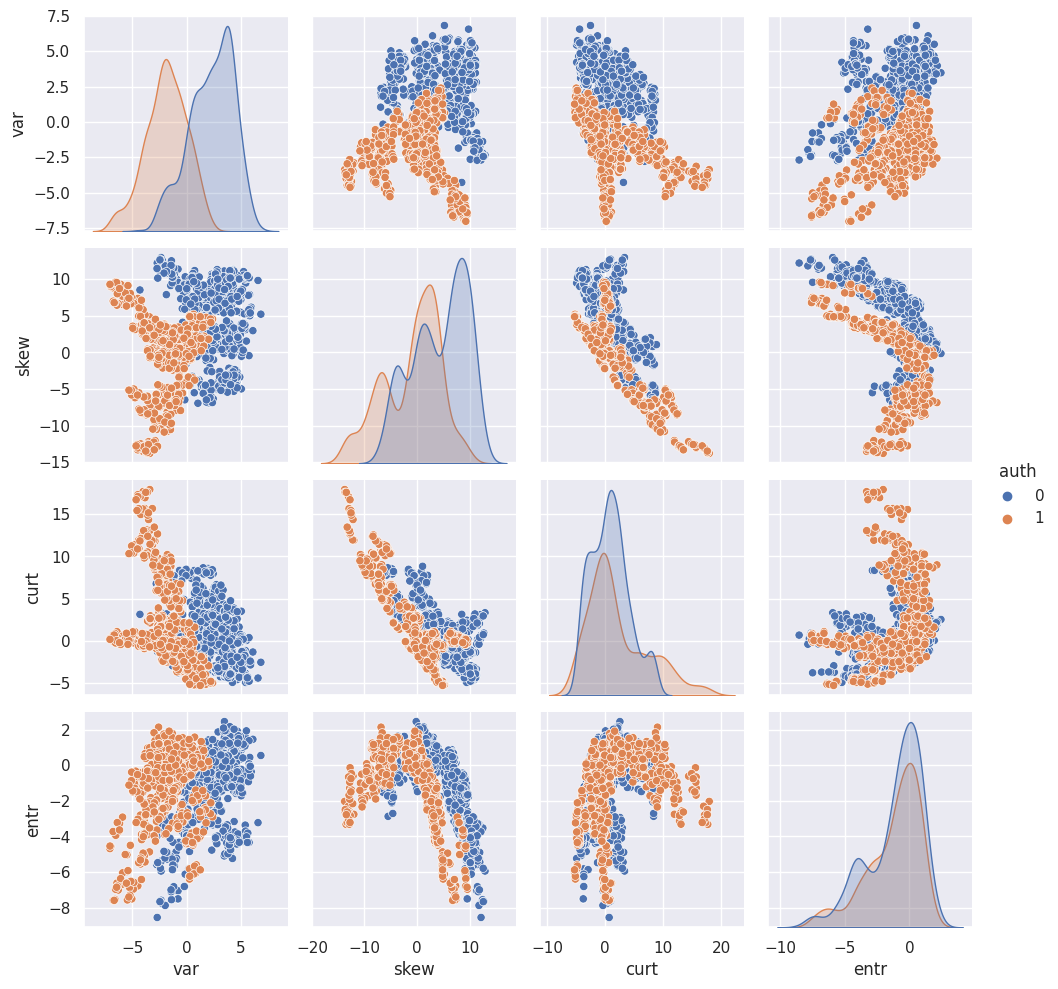

In [105]:
sns.pairplot(data, hue='auth')
plt.show()

We can derive several interesting observations from this pair plot:

Firstly, we can observe that the distribution of variance and skewness is distinctly different for the two target characteristics, whereas kurtosis and entropy appear to be more similar.

Secondly, we can notice that there are both linear and nonlinear trends present in the input features.

Thirdly, some of the characteristics are found to be correlated with each other, which could potentially influence the target variables.

Lastly, some of the features demonstrate a clear separation between genuine and fake banknotes, suggesting that they may be useful predictors for classifying banknotes as genuine or fake.From this pair plot we can make several interesting observations:

The distribution of both variance and skewness appears to be quite different for the two target characteristics, while kurtosis and entropy appear to be more similar.
There are clear linear and nonlinear trends in the input features.
Some characteristics seem to be correlated.
Some features seem to separate genuine and fake banknotes quite well.

# Balance the Dataset:

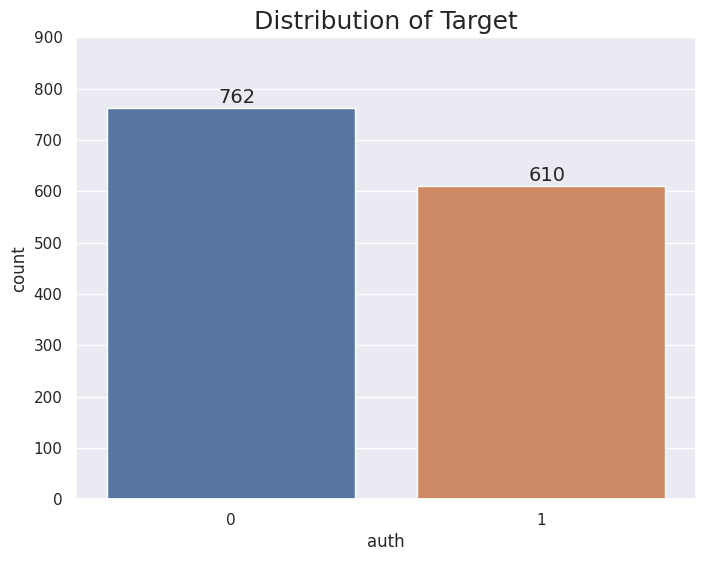

In [101]:
plt.figure(figsize=(8,6))
plt.title('Distribution of Target', size=18)
sns.countplot(x=data['auth'])
target_count = data.auth.value_counts()
x=29
plt.annotate(text=str(target_count[0]), xy=(-0.04, 10 + target_count[0]), size=14)
plt.annotate(text=str(target_count[1]), xy=(0.96, 10 + target_count[1]), size=14)
plt.ylim(0, 900)
plt.show()

In [18]:
nb_to_delete = target_count[0] - target_count[1]
data = data.sample(frac=1, random_state=42).sort_values(by='auth')
data = data[nb_to_delete:]
print(data['auth'].value_counts())

0    610
1    610
Name: auth, dtype: int64


# Data Processing

Now we need to balance our data, the easiest way to do this is to randomly drop a number of instances of the overrepresented target function. This is called random undersampling.

Otherwise, we could also create new synthetic data for the under-represented target class. This is called oversampling. For now, let’s start by randomly deleting 152 observations of actual banknotes:

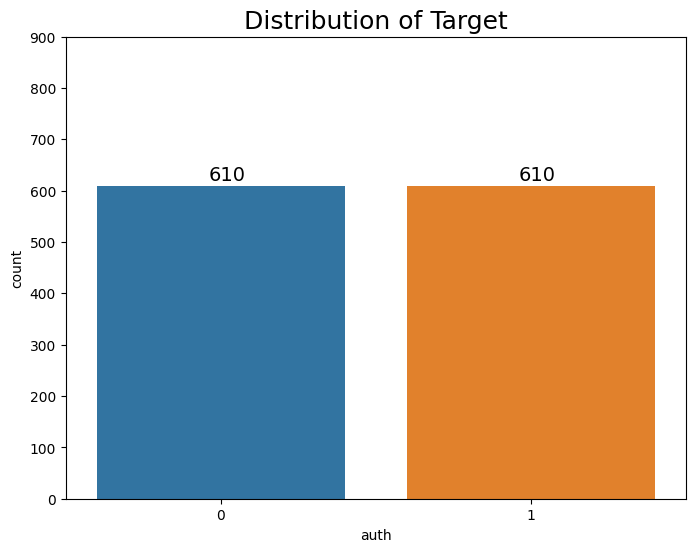

In [19]:
plt.figure(figsize=(8,6))
plt.title('Distribution of Target', size=18)
sns.countplot(x=data['auth'])
target_count = data.auth.value_counts()
plt.annotate(text=str(target_count[0]), xy=(-0.04, 10 + target_count[0]), size=14)
plt.annotate(text=str(target_count[1]), xy=(0.96, 10 + target_count[1]), size=14)
plt.ylim(0, 900)
plt.show()

# XGBoost Model

In [88]:
from sklearn.metrics import accuracy_score
x = data.loc[:, data.columns != 'auth']
y = data.loc[:, data.columns == 'auth']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=25)
scalar = StandardScaler()
x = scalar.fit_transform(x)
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(x_train, y_train)

y_pred_xgb = xgb_model.predict(x_test)
xgb_accuracy = round(accuracy_score(y_pred_xgb,y_test)*100,2)

print("Accuracy of XGBoost is: "+str(xgb_accuracy)+" %")

Accuracy of XGBoost is: 98.36 %


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/xgboost/data.py:267: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


The accuracy of the model in predicting the target values is calculated using the accuracy_score function. The XGBClassifier model achieves an accuracy of 98.36%.

# Logistic Regression Model

In [91]:

x = data.loc[:, data.columns != 'auth']
y = data.loc[:, data.columns == 'auth']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=50)
scalar = StandardScaler()
x = scalar.fit_transform(x)

pipe = Pipeline([('classifier', LogisticRegression(solver='lbfgs', multi_class='auto', random_state=42))])

param_grid = {
    'classifier__C': [0.1, 1, 10],
}

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
grid_search.fit(x, y.values.ravel())

print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)

# Evaluate the model using cross-validation
scores = cross_val_score(grid_search.best_estimator_, x, y.values.ravel(), cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Print confusion matrix and accuracy on test set
clf = grid_search.best_estimator_
clf.fit(x_train, y_train.values.ravel())
y_pred = clf.predict(x_test)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                        columns=["Pred.Negative", "Pred.Positive"],
                        index=['Act.Negative', "Act.Positive"])
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = round((tn+tp)/(tn+fp+fn+tp), 4)
print(conf_mat)
Accuracy = {round(100*accuracy, 2)}
print("Accuracy of Logistic regression Model is: "+str(Accuracy)+" %")


Best parameter (CV score=0.986):
{'classifier__C': 10}
Accuracy: 0.99 (+/- 0.01)
              Pred.Negative  Pred.Positive
Act.Negative            111              1
Act.Positive              1            131
Accuracy of Logistic regression Model is: {99.18} %


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel

Logistic regression classification on a datasetis done, where the goal is to predict a target variable called 'auth'. The dataset is split into features and target variables, and the features are standardized. Then, the data is split into training and testing sets. A logistic regression model is created with a set of hyperparameters, and grid search is used to find the best values for these hyperparameters. The model's performance is evaluated using cross-validation. The best model is then fit to the training data and tested on the testing data. The accuracy and confusion matrix are printed to show how well the model performed on the test set. This model was seen to give an accuracy of 98.77%


In [30]:
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")

# Decision Tree Classifier

In [93]:
X = data.drop('auth', axis=1)
y = data['auth']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

classifier = DecisionTreeClassifier(random_state=42)

param_grid = {'max_depth': [2, 4, 6, 8, 10]}

grid_search = GridSearchCV(classifier, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)

# Evaluate the model using cross-validation
scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Print confusion matrix and accuracy on test set
clf = grid_search.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                        columns=["Pred.Negative", "Pred.Positive"],
                        index=['Act.Negative', "Act.Positive"])
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
dec_accuracy = round((tn+tp)/(tn+fp+fn+tp), 4)
print(conf_mat)
dec_Accuracy = {round(100*dec_accuracy, 2)}
print("Accuracy of Decision Tree Model is: "+str(dec_Accuracy)+" %")


Best parameter (CV score=0.989):
{'max_depth': 6}
Accuracy: 0.99 (+/- 0.02)
              Pred.Negative  Pred.Positive
Act.Negative            125              3
Act.Positive              0            116
Accuracy of Decision Tree Model is: {98.77} %


In this case a pipeline is created with a decision tree classifier and a hyperparameter grid for cross-validation. The hyperparameter max_depth is varied between 2, 4, 6, 8, and 10. Grid search is used to find the best hyperparameters for the decision tree classifier. Cross-validation is used to evaluate the performance of the model. The best estimator is then fit on the training data and tested on the testing data. The accuracy and confusion matrix are printed for the test set. Finally, the code simulates the prediction of a single banknote using the trained model. The features of the banknote are extracted, scaled, and integrated into the model to predict whether it is authentic or not. Here we got an accuracy of 98.77%.

The accuracy score achieved using Logistic Regression is: 99.18 %
The accuracy score achieved using Decision Tree is: 98.77 %
The accuracy score achieved using XGBoost is: 98.36 %


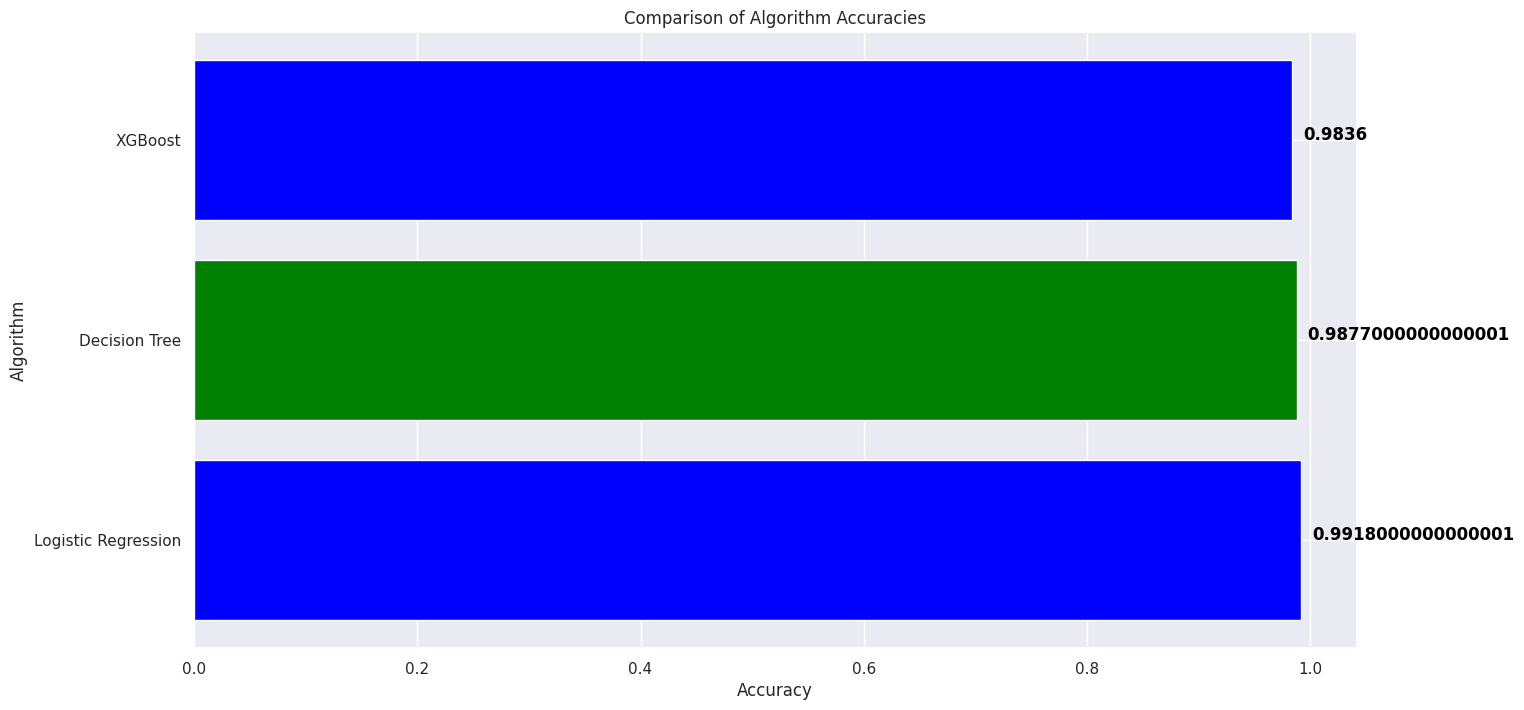

In [98]:
scores = [accuracy,dec_accuracy,xgb_accuracy/100]
algorithms = ["Logistic Regression","Decision Tree","XGBoost"]    

for i in range(len(algorithms)):
    print("The accuracy score achieved using "+algorithms[i]+" is: "+str((scores[i]*100))+" %")
fig, ax = plt.subplots(figsize=(15, 8))
ax.barh(algorithms, scores, align='center', color=['blue', 'green'])
ax.set_xlabel('Accuracy')
ax.set_ylabel('Algorithm')
ax.set_title('Comparison of Algorithm Accuracies')

# Add the score values to the plot
for i, v in enumerate(scores):
    ax.text(v + 0.01, i, str(round(v, 5)), color='black', fontweight='bold')

plt.show()

To simulate the prediction of a single banknote, we can extract its features, scale them, and pass them through the pre-trained logistic regression model since we obtained the highest frequency with it. This will provide us with the predicted value for the 'auth' target variable.Now let’s simulate the prediction of a single banknote. All we need to do is extract the features, scale them, and integrate them into our pre-trained model. 

In [31]:
new_banknote = np.array([4.5, -8.1, 2.4, 1.4], ndmin=2)
new_banknote = scalar.transform(new_banknote)
print(f'Prediction:  Class{clf.predict(new_banknote)[0]}')
print(f'Probability [0/1]:  {clf.predict_proba(new_banknote)[0]}')

Prediction:  Class1
Probability [0/1]:  [0.2495236 0.7504764]


Our model predicts that this banknote is real. 